## Problem Statement
Given the transaction history of credit cards we have to predict the transactions as fraudulent or non-fraudulent. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Background
Suppose one day you wake up and recieve a message on your text that some amount has been deducted from your card for some purchase of say item 'x'. But you didn't made any purchase from your card, someone with your card cardentials or by any anhyhow has made a purchase through your card.It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The banks fraud detection system saves you from these kind of fraudulent activities.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

seed = 999

## Data Definition
* The datasets contains transactions made by credit cards in September 2013 by european cardholders.
* This dataset contains 284,807 records and 31 features.  
* Features V1, V2, … V28 are the principal components obtained with PCA. 
* The only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time'.
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
train = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

### Check Data

In [ ]:
#check shape 
print(f'data has {train.shape[0]} number of rows and {train.shape[1]} number of columns')

### Check head of the data

In [ ]:
train.head(10)

### Check the Information

In [ ]:
train.info()

Fron information we can check that there are only numeric features only.

### Check Null Values

In [ ]:
train.isnull().sum()

There are no null values present in our dataset.

### Check Description

In [ ]:
train.describe().T

All the V-columns are principal components. The Time and Amount columns are not anonymized.
When we look at the Amount column mean is 22 while the maximum is 25691. The data seems to be positively skewed. Another thing we can observe is that the time is given in seconds minimum is 0 and maximum is 172792. In one day we have 86,400 sec, so if we divide 172972/86,400 we will see that the data is of nearly 2 days.

## Exploratory Data Analysis
Since all the features are anonymized. We will focus our EDA on Time, Amount and target feature (Class).

### Plot Histogram to check the distribution of Amount

In [ ]:
sns.distplot(train['Amount'])
plt.title('Amount Distribution',fontsize=20)
plt.show()

**Interpretation from the graph**
* Amount is positively skewed.
* Most of the transaction amounts are low only few comes close to maximum.

### Plot histogram to see distribution of time

In [ ]:
plt.hist(train['Time'])
plt.title('Distribution of Time',fontsize=20)
plt.xlabel('Time')
plt.show()

**Interpretations from the graph**
* Time is Bimodal.
* Number of transactions has dropped between the two mode. May be because it was night time.

### Check the Target column (Class)

In [ ]:
sns.countplot(train['Class'])
plt.title('Class Counts',fontsize=20)
plt.show()

**Interpretations from the graph**
* Class is highly imbalanced
* There are very less positive class as compared to negative class

### Count percentage of positive and negative class

In [ ]:
train['Class'].value_counts()/train.shape[0]  #check percentage of positive and negative class

About 99.8273 % are negative (Non-Fraudulent) cases in our dataset and only 0.1727% are positive cases. It is going to impact the evaluation metric that we choose as if we simply choose the accuracy score as our evaluation metric it will always give us a good high score even if we classify all the positive classes as negative. We will be using ROC_AUC score as our evaluation metric here.  

### Check the Distibution of fraudulent and non-fraudulent transactions seperately

In [ ]:
fraud_cases = train[train['Class'] == 1]  #keep all the fraud cases 
non_fraud_cases = train[train['Class'] == 0]  #keep all the non-fraud cases

### Plot histogram to check the distribution of fraud cases

In [ ]:
#Distribution of amount in fraud cases
plt.hist(fraud_cases['Amount'])
plt.title('Distribution of Amount for fraudulent cases',fontsize=20)
plt.show()

**Interpretations**
* Amount is heavily positively skewed.
* Few transaction amounts have higher values.
* Most of the transaction amounts are low

### Plot histogram to check the distribution of fraud cases

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(non_fraud_cases['Amount'])
plt.title('Distribution of Amount for non-fraudulent cases')
plt.show()

**Interpreations**
* Transaction amount for non-fraud cases are mostly small.
* Most of the Amounts are between 0 and 500. 
* From above 2 graphs we can say that the fraudulent cases have more transaction amounts.

### Plot the Distribution of Time for fraud and non-fraud cases

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(fraud_cases['Time'])
plt.title('Distribution of Time for fraudulent cases')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(non_fraud_cases['Time'])
plt.title('Distribution of Time for non-fraudulent cases')
plt.show()

### Check the Correlation between the variables using Heatmap

In [ ]:
plt.figure(figsize=(17,8))
cor = train.corr()
cor
#sns.heatmap(cor,annot=True,fmt='.2g')

In [ ]:
plt.figure(figsize=(17,8))
cor = train.corr()
sns.heatmap(cor,annot=True,fmt='.2g')

## Data Preperation

### Scale Amount and Time

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train['Amount'] = sc.fit_transform(train[['Amount']])
train['Time'] = sc.fit_transform(train[['Time']])

## Handling Imbalanced Class
To handle class imbalance mostly used techniques are -
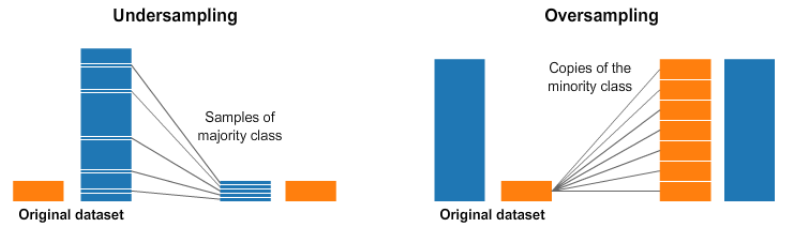
* **Random Over Sampling**
    
    In over sampling we make the instances of minority class equal to the majority class. Suppose out of  100 there are only 2 fraud cases. By over sampling  we make the instances of fraud cases from 2 to 100 by duplicating.
    
* **Random Down Sampling**

    In random down sampling we make the instances of majority class equal to minority class. In our previous example down sampling will result in 2 cases of frauds and 2 cases of non-frauds.

Each of these techniques possess challenges as well. If our dataset is very big then **over sampling will make our dataset even bigger. And there will be time complexity as we are almost doubling the dataset and if we Down sample the minority classes we will miss the instances and specific patterns present in our dataset.**


While splitting our dataset into training and testing we should make sure to have same proportion of classes in both training and testing set as it was there in original dataset.

### Split the data into train and test


In [ ]:
# keep all the predictor variables in X and Classes in Y
X = train.drop('Class', axis=1)
Y = train['Class']

In [ ]:
#Check the shape of X and Y
print('Shape of X and Y')
print(X.shape)
print(Y.shape)

In [ ]:
#split the data into 67:33 ratio for training and testing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, stratify = Y, test_size = .33, random_state = 42)

#check proportion of fraud and non-fraud cases in tarining and testing sets

print('Proportion of classes in training set')
print(Y_train.value_counts() / len(Y_train))

print('Proportion of classes in test set')
print(Y_test.value_counts() / len(Y_test))

Both the classes are present in almost equal proportion in taraining and testing set.

## Model Building
As we have a binary classification problem here i.e to predict the transactions as fraudulent and non-fraudulent. We will apply the logistic regression on on our datset. We will tune only the signle parameter **C** using GridSearchCV. Then we will check the auc_score as specified and look at the confusion matrix. Then we try to set the threshold which gives our model confidence to predict the fraudulent transactions. To read about Roc Auc score [Click Here](https://www.dataschool.io/roc-curves-and-auc-explained/)

In [ ]:
from sklearn.model_selection import GridSearchCV #import GridSearchCV to find best parameters
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix #import metrices

clf = LogisticRegression(verbose=3,warm_start=True) #create instance of LogisticRegression
params = {'C' : np.power(10.0, np.arange(-3,3))} #set c parameter

#find best parameter value for c
logit_grid = GridSearchCV(clf, param_grid = params, scoring='roc_auc', n_jobs=70)
logit_grid.fit(X_train,Y_train) #fit model on training set
predict = logit_grid.predict(X_test) #predict for test set

### Check roc_auc_score

In [ ]:
#check the roc_auc_score
print('Training score ',roc_auc_score(Y_train,logit_grid.predict(X_train)))
print('Testing score ',roc_auc_score(Y_test,predict))

### Plot confusion matrix

In [ ]:
#Plot confusion matric
from sklearn.metrics import plot_confusion_matrix
conf = confusion_matrix(Y_train,logit_grid.predict(X_train))
sns.heatmap(conf,annot=True,fmt='d')
plt.ylabel('ACtual Class')
plt.xlabel('Predicted Class')
plt.show()

### Plot FPR vs TPR 

In [ ]:
pred_probas = logit_grid.predict_proba(X_train)[:, 1]
fpr,tpr, thresholds = roc_curve(Y_train,pred_probas)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axvline(0.1,linestyle='--')
plt.show()

### Set The Threshold

In [ ]:
# we will set the threshold as 0.1
predicted_class = []
for i in pred_probas:
    if i > 0.1:
        predicted_class.append(1)
    else:
        predicted_class.append(0)

In [ ]:
plt.figure(figsize=(8,5))
from sklearn.metrics import plot_confusion_matrix
conf = confusion_matrix(Y_train,predicted_class)
sns.heatmap(conf,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('ACtual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
roc_auc_score(Y_train,predicted_class)

## Conclusion
By using Stratified sampling and setting the threshold of our Logistic Regression model to 0.1 we were able to build a model which can classify the Transactions as fraudulent and non-fraudulent with roc_auc_score of 83.7%